# Spotify Playbook

### Using `spotipy` to explore playlists

See [here](https://spotipy.readthedocs.io/en/2.22.1/) for more info on `spotipy`:
> Spotipy is a lightweight Python library for the Spotify Web API. With Spotipy you get full access to all of the music data provided by the Spotify platform.

Here's how to use it to pull down a playlist. Note that you can supply the playlist id either as a URL or a URI. You can get either from the Spotify web app as outlined [here](https://community.spotify.com/t5/Desktop-Mac/URI-no-longer-a-share-option/td-p/5179876).

In [1]:
import os
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json

def dumpPlaylist(playlist):
    print(json.dumps(playlist, indent=4))

def processTrack(sp, track):
    d = {}
    # URI
    track_uri = track["track"]["uri"]
    d['track_uri'] = track_uri
    
    # Track name
    track_name = track["track"]["name"]
    d['track_name'] = track_name
 
    # Main Artist
    artist_uri = track["track"]["artists"][0]["uri"]
    artist_info = sp.artist(artist_uri)
    d['artist_uri'] = artist_uri
    #d['artist_info'] = artist_info
    d['artist_url'] = artist_info["external_urls"]["spotify"]
    d['artist_followers'] = artist_info["followers"]["total"]
    
    #Name, popularity, genre
    d['artist_name'] = track["track"]["artists"][0]["name"]
    d['artist_pop'] = artist_info["popularity"]
    d['artist_genres'] = artist_info["genres"]
    
    #Album
    album = track["track"]["album"]["name"]
    d['album'] = album
    
    #Popularity of the track
    track_pop = track["track"]["popularity"]
    d['track_popularity'] = track_pop
    d['audio_features'] = sp.audio_features(track_uri)[0]
    return d
    
def processPlaylist(sp, playlist):
    details = {}
    tracks = []
    details['name'] = playlist.get('name')
    details['url'] = playlist.get('external_urls').get('spotify')
    details['image_url'] = playlist.get('images')[0].get('url')
    details['owner_url'] = playlist.get('owner').get('href')
    details['public'] = playlist.get('public')
    for track in playlist.get('tracks').get('items'):
        tracks.append(processTrack(sp, track))
    return details, tracks
    
def getSpotifyManager(client_id, client_secret):
    client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
    sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)
    return sp

CLIENT_ID = os.environ.get("SPOTIFY_CLIENT_ID")
CLIENT_SECRET = os.environ.get("SPOTIFY_CLIENTSECRET")
sp = getSpotifyManager(CLIENT_ID, CLIENT_SECRET)
playlist_id = 'spotify:playlist:3Shvf5m5SePuQpzJHan9i2' # URI
#playlist_id = 'https://open.spotify.com/playlist/3Shvf5m5SePuQpzJHan9i2' # URL
results = sp.playlist(playlist_id)
#dumpPlaylist(results)
details,tracks = processPlaylist(sp, results)

Let's have a look at the playlist url and image:

In [2]:
from IPython.display import display, HTML, IFrame

url = details.get('url')
display(HTML(url))

Let's put all the tracks into a `pandas` dataframe:

In [3]:
import pandas as pd

df = pd.DataFrame(tracks)
df.head()

,track_uri,track_name,artist_uri,artist_url,artist_followers,artist_name,artist_pop,artist_genres,album,track_popularity,audio_features
0,spotify:track:3mZ33QYHWylbabTz82rHwj,So What,spotify:artist:0kbYTNQb4Pb1rPbbaF0pT4,https://open.spotify.com/artist/0kbYTNQb4Pb1rP...,2419579,Miles Davis,61,"[cool jazz, hard bop, jazz, jazz fusion, jazz ...",Pleasantville -Music From The Motion Picture,31,"{'danceability': 0.505, 'energy': 0.189, 'key'..."
1,spotify:track:1YQWosTIljIvxAgHWTp7KP,Take Five,spotify:artist:4iRZAbYvBqnxrbs6K25aJ7,https://open.spotify.com/artist/4iRZAbYvBqnxrb...,253470,The Dave Brubeck Quartet,55,"[bebop, jazz, jazz quartet]",Time Out,70,"{'danceability': 0.454, 'energy': 0.26, 'key':..."
2,spotify:track:3ZikLQCnH3SIswlGENBcKe,My Favorite Things,spotify:artist:2hGh5VOeeqimQFxqXvfCUf,https://open.spotify.com/artist/2hGh5VOeeqimQF...,1538061,John Coltrane,63,"[bebop, free jazz, jazz, jazz saxophone, vocal...",My Favorite Things,49,"{'danceability': 0.277, 'energy': 0.242, 'key'..."
3,spotify:track:3PJMsxg6rz9FOo6xNiASXz,Goodbye Pork Pie Hat,spotify:artist:1W8TbFzNS15VwsempfY12H,https://open.spotify.com/artist/1W8TbFzNS15Vws...,435059,Charles Mingus,47,"[avant-garde jazz, bebop, contemporary post-bo...",Mingus Ah Um,56,"{'danceability': 0.356, 'energy': 0.0937, 'key..."
4,spotify:track:0aWMVrwxPNYkKmFthzmpRi,Blue in Green (feat. John Coltrane & Bill Evans),spotify:artist:0kbYTNQb4Pb1rPbbaF0pT4,https://open.spotify.com/artist/0kbYTNQb4Pb1rP...,2419579,Miles Davis,61,"[cool jazz, hard bop, jazz, jazz fusion, jazz ...",Kind Of Blue (Legacy Edition),66,"{'danceability': 0.421, 'energy': 0.0162, 'key..."


Let's have a quick look at track popularity by name:

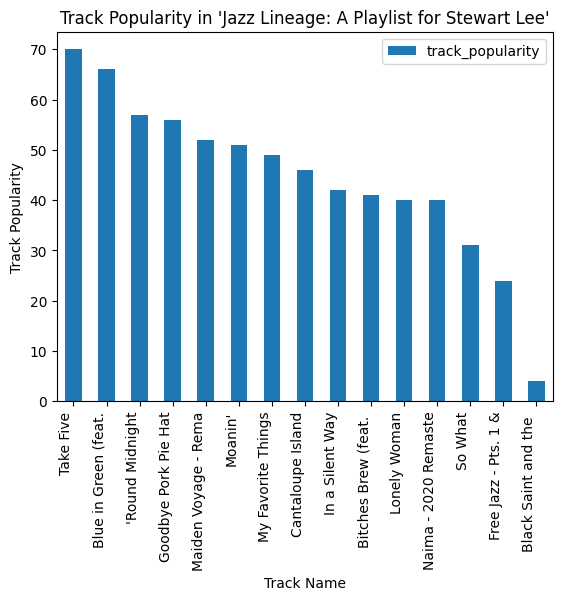

In [4]:
def plotPopularity(name):
    ax = df.sort_values(by='track_popularity',ascending=False).plot(kind='bar', x='track_name', y='track_popularity')
    ax.set_xlabel("Track Name")
    ax.set_ylabel("Track Popularity")
    ax.set_title(f"Track Popularity in '{name}'")
    labels = [name[:20] for name in df.sort_values(by='track_popularity',ascending=False)['track_name']]
    ax.set_xticklabels(labels, rotation=90, ha="right")

plotPopularity(details.get('name'))

### Conducting a Spotify streaming history analysis

See [here](https://github.com/jayeshironside/Spotify-Streaming-history-analysis) for more details on how to analyse your streaming history.  You first need to download your Spotify data locally.  If you are logged in on a browser you can do that by going to [https://www.spotify.com/uk/account/privacy/](https://www.spotify.com/uk/account/privacy/).  Scroll down and you should see the following.  It takes up to 5 days for the link to be emailed to you.

<img src= "DataCopy.png" width=400\>